In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os
import time
cwd = os.getcwd()
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)


def settings_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='=')
        output = dict()
        for row in reader:
            output[row[0]] = row[1]
    return output


def csv_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if zeroth_row == True:
                row.remove('')
                row = [float(value) for value in row]
                data = np.array(row)
                zeroth_row = False
            else:
                row.remove('')
                new_row = [float(value) for value in row]
                data = np.vstack([data, new_row])
    return data


def mean_photons_calc(probabilities):
    photons = np.zeros(probabilities.shape[1])
    for i in range(photons.shape[0]):
        for j in range(probabilities.shape[0]):
            photons[i] = photons[i] + j * probabilities[j, i]
    return photons


def times_qload(folder_path):
    times_path = folder_path + '/times'
    times = qload(times_path)
    times = times / (2 * np.pi * 1000)
    return times


def above(x, y, trials):
    difference = y[:, :, np.newaxis] - divider(x, trials)
    above_yn = difference > 0
    return above_yn


class Parameters:
    def __init__(self, wc, wq, eps, g, chi, kappa, gamma, t_levels, c_levels):
        self.wc = wc
        self.wq = wq
        self.eps = eps
        self.g = g
        self.chi = chi
        self.gamma = gamma
        self.kappa = kappa
        self.t_levels = t_levels
        self.c_levels = c_levels

    def copy(self):
        params = Parameters(self.wc, self.wq, self.eps, self.g, self.chi, self.kappa, self.gamma, self.t_levels, self.c_levels)
        return params


class Results:
    def __init__(self, params=np.array([]), wd_points=np.array([]),
                 transmissions=np.array([]), edge_occupations_c=np.array([]), edge_occupations_t=np.array([])):
        self.params = params
        self.wd_points = wd_points
        self.transmissions = transmissions
        self.edge_occupations_c = edge_occupations_c
        self.edge_occupations_t = edge_occupations_t
        self.abs_transmissions = np.absolute(self.transmissions)
        self.size = self.wd_points.size

    def concatenate(self, results):
        combined_params = np.concatenate([self.params, results.params])
        combined_wd_points = np.concatenate([self.wd_points, results.wd_points])
        combined_transmissions = np.concatenate([self.transmissions, results.transmissions])
        combined_edge_occupations_c = np.concatenate([self.edge_occupations_c, results.edge_occupations_c])
        combined_edge_occupations_t = np.concatenate([self.edge_occupations_t, results.edge_occupations_t])
        sort_indices = np.argsort(combined_wd_points)
        combined_params = combined_params[sort_indices]
        combined_wd_points = combined_wd_points[sort_indices]
        combined_transmissions = combined_transmissions[sort_indices]
        combined_edge_occupations_c = combined_edge_occupations_c[sort_indices]
        combined_edge_occupations_t = combined_edge_occupations_t[sort_indices]
        combined_results = Results(combined_params, combined_wd_points,
                                   combined_transmissions, combined_edge_occupations_c, combined_edge_occupations_t)
        return combined_results

    def delete(self, indices):
        reduced_params = np.delete(self.params, indices)
        reduced_wd_points = np.delete(self.wd_points, indices)
        reduced_transmissions = np.delete(self.transmissions, indices)
        reduced_edge_occupations_c = np.delete(self.edge_occupations_c, indices)
        reduced_edge_occupations_t = np.delete(self.edge_occupations_t, indices)
        reduced_results = Results(reduced_params, reduced_wd_points,
                                  reduced_transmissions, reduced_edge_occupations_c, reduced_edge_occupations_t)
        params_change = (reduced_params == self.params)
        wd_points_change = (reduced_wd_points == self.wd_points)
        transmissions_change = (reduced_transmissions == self.transmissions)
        edge_occupations_c_change = (reduced_edge_occupations_c == self.edge_occupations_c)
        edge_occupations_t_change = (reduced_edge_occupations_t == self.edge_occupations_t)
        print np.all([params_change, wd_points_change, transmissions_change, edge_occupations_c_change, edge_occupations_t_change])
        return reduced_results

    def queue(self):
        queue = Queue(self.params, self.wd_points)
        return queue


def fidelity_calc(set1, set2, trials):
    
    set1_above = np.sum(above(set1[0, :, :], set1[1, :, :], trials), axis=0)
    set1_total = set1.shape[1]
    set1_above_fraction = 1.0 * set1_above / set1_total
  
    set2_above = np.sum(above(set2[0, :, :], set2[1, :, :], trials), axis=0)
    set2_total = set2.shape[1]
    set2_above_fraction = 1.0 * set2_above / set2_total
       
    fidelity = 0.5 * (1 + np.abs(set1_above_fraction - set2_above_fraction))
    
    return fidelity


def initial_parameters_calc(set1, set2):
    set1_mean = np.mean(set1, axis=1)
    set2_mean = np.mean(set2, axis=1)
    midpoint = np.mean(np.array([set1_mean, set2_mean]), axis = 0)
    difference = set2_mean - set1_mean
    grad = difference[1] / difference[0]
    theta = np.arctan(-1 / grad)    
    return np.array([theta, midpoint[0], midpoint[1]]), difference


def divider(x, trials):
    y = (x[:, :, np.newaxis] - trials[1, np.newaxis, :, :]) * np.tan(trials[0, np.newaxis, :, :]) + trials[2, np.newaxis, :, :]
    return y
#traj, trial
#now traj, trial, timeslice
#trials feed in as parameter, timeslice, trial
#out traj, timeslice, trial
#x in traj, timeslice


def best_guess(set1, set2, trials):
    fidelities = fidelity_calc(set1, set2, trials)
    max_idx = np.argmax(fidelities, axis=1)
    best = np.zeros([3, max_idx.shape[0]])
    for i, j in enumerate(max_idx):
        best[:, i] = trials[:, i, j]
    return best

    
def new_trials(initial_trial, param_idx, region, points):
    trials = np.zeros([3, region.shape[0], points])
    for idx, reg in enumerate(region):
        trials[param_idx, idx, :] = np.linspace(-reg/2, reg/2, points)
    trials = trials + initial_trial[:, :, np.newaxis]
    return trials


def optimize(set1, set2):

    initial_trials, differences = initial_parameters_calc(set1, set2)
    theta_range = np.pi * np.ones([set1.shape[2]])
    x_range = np.linalg.norm(differences, axis=0)
    y_range = np.linalg.norm(differences, axis=0)
    n_trials = 99
    n_iterations = 5
    refinement = 1.2
    best_trials = initial_trials
    
    for idx in range(n_iterations):
        trials = new_trials(best_trials, 0, theta_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 1, x_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 2, y_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        theta_range = theta_range / refinement
        x_range = x_range / refinement
        y_range = y_range / refinement
    
    best_fidelities = fidelity_calc(set1, set2, best_trials[:, :, np.newaxis])
    
    return best_fidelities, best_trials
    


In [5]:
class Run:
    def __init__(self):
        self.diff_d_I = None
        self.diff_d_Q = None
        self.diff_d_p = None
        self.diff_d_mp = None
        self.diff_u_I = None
        self.diff_u_Q = None
        self.diff_u_p = None
        self.diff_u_mp = None
        self.master_d_p = None
        self.master_d_mp = None
        self.master_u_p = None
        self.master_u_mp = None
        self.steady_state = None
        self.fidelities = None
        self.divide_params = None
        self.fidelity_times = None
        self.unint_fidelities = None
        self.unint_divide_params = None
        self.diff_d_I_m = None
        self.diff_d_Q_m = None
        self.diff_u_I_m = None
        self.diff_u_Q_m = None
        self.diff_d_mag = None
        self.diff_d_phase = None
        self.diff_u_mag = None
        self.diff_u_phase = None 
        self.diff_sep_I = None
        self.diff_sep_Q = None
        self.diff_sep_mag = None
        self.diff_sep_phase = None
        self.diff_sep_mag_sq = None
        


def sweep_load(directory, dp=4, update=False, fidelity_calc=True):
    
    if os.path.isfile(directory + '/sweep.npy') and not update:
        sweep_class = np.load(directory + '/sweep.npy')[()]
        return sweep_class
    
    sweep = dict()
    
    subdir = directory + '/master/down'
    if os.path.isdir(subdir):
        paths = [x[0] for x in os.walk(subdir)]
        del paths[0]
        for path in paths:
            master_down = qload(path + '/expectations')   
            for key in master_down:
                r_key = round(key, dp)
                if r_key not in sweep:
                    sweep[r_key] = Run()
                sweep[r_key].master_d_p = master_down[key]
                sweep[r_key].master_d_mp = mean_photons_calc(sweep[r_key].master_d_p)
    
    
    subdir = directory + '/master/up'
    if os.path.isdir(subdir):
        paths = [x[0] for x in os.walk(subdir)]
        del paths[0]
        for path in paths:
            master_up = qload(path + '/expectations')
            times = times_qload(path)  
            for key in master_up:
                r_key = round(key, dp)
                if r_key not in sweep:
                    sweep[r_key] = Run()
                sweep[r_key].master_u_p = master_up[key]
                sweep[r_key].master_u_mp = mean_photons_calc(sweep[r_key].master_u_p)
    
    
    subdir = directory + '/steady_state'
    if os.path.isdir(subdir):
        paths = [x[0] for x in os.walk(subdir)]
        del paths[0]
        for path in paths:
            steady_states = qload(path + '/density_matrix')
            for key in steady_states:
                r_key = round(key, dp)
                if r_key not in sweep:
                    sweep[r_key] = Run()
                sweep[r_key].steady_state = steady_states[key]
    
    
    subdir = directory + '/spectroscopy'
    if os.path.isdir(subdir):
        paths = [x[0] for x in os.walk(subdir)]
        del paths[0]
        spectrum = None
        for path in paths:
            spec_results = qload(path + '/spectroscopy')
            spec_keys = spec_results.keys()
            if spectrum:
                spectrum = spectrum.concatenate(spec_results[spec_keys[0]])
            else:
                spectrum = spec_results[spec_keys[0]]
    
    subdir = directory + '/diffusive/down'
    if os.path.isdir(subdir):
        run_dirs = [x[0] for x in os.walk(subdir)]
        del run_dirs[0]
        
        n_dirs = len(run_dirs)
            
        for i, run in enumerate(run_dirs):
            print "Down progress = " + str(1.0*i/n_dirs)
            settings_path = run + '/settings.cfg'
            settings = settings_load(settings_path)
            drive_frequency = float(settings['omega_d'])
            drive_frequency = round(drive_frequency, dp)
            if drive_frequency not in sweep:
                sweep[drive_frequency] = Run()
            I_path = run + '/ReaverageAlpha9.dat'
            Q_path = run + '/ImaverageAlpha9.dat'
            p_path = run + '/photons9.dat'
            sweep[drive_frequency].diff_d_I = csv_load(I_path)
            sweep[drive_frequency].diff_d_Q = csv_load(Q_path)
            sweep[drive_frequency].diff_d_p = csv_load(p_path)
            sweep[drive_frequency].diff_d_mp = np.mean(sweep[drive_frequency].diff_d_p, axis=0)
    
   
    subdir = directory + '/diffusive/up'
    if os.path.isdir(subdir):
        run_dirs = [x[0] for x in os.walk(subdir)]
        del run_dirs[0]

        n_dirs = len(run_dirs)
            
        for i, run in enumerate(run_dirs):
            print "Up progress = " + str(1.0*i/n_dirs)
            settings_path = run + '/settings.cfg'
            settings = settings_load(settings_path)
            drive_frequency = float(settings['omega_d'])
            drive_frequency = round(drive_frequency, dp)
            if drive_frequency not in sweep:
                 sweep[drive_frequency] = Run()
            I_path = run + '/ReaverageAlpha9.dat'
            Q_path = run + '/ImaverageAlpha9.dat'
            p_path = run + '/photons9.dat'
            sweep[drive_frequency].diff_u_I = csv_load(I_path)
            sweep[drive_frequency].diff_u_Q = csv_load(Q_path)
            sweep[drive_frequency].diff_u_p = csv_load(p_path)
            sweep[drive_frequency].diff_u_mp = np.mean(sweep[drive_frequency].diff_u_p, axis=0)
    
    
    if fidelity_calc:
        sparsify = 20
        shared_keys = []
        for key in sweep:
            if sweep[key].diff_d_I is not None and sweep[key].diff_u_I is not None:
                shared_keys.append(key)
    
        for key in shared_keys:
            I_u = sweep[key].diff_u_I
            Q_u = sweep[key].diff_u_Q
            I_d = sweep[key].diff_d_I
            Q_d = sweep[key].diff_d_Q
    
            I_u_int = np.cumsum(I_u, axis=1)
            Q_u_int = np.cumsum(Q_u, axis=1)
            I_d_int = np.cumsum(I_d, axis=1)
            Q_d_int = np.cumsum(Q_d, axis=1)
    
            set1 = np.array([I_u_int[:,1::sparsify], Q_u_int[:,1::sparsify]])
            set2 = np.array([I_d_int[:,1::sparsify], Q_d_int[:,1::sparsify]])
            fidelity_times = times[1::sparsify]
            sweep[key].fidelity_times = fidelity_times        
            sweep[key].fidelities, sweep[key].divide_params = optimize(set1, set2)
    
    sweep_instance = Sweep()
    sweep_instance.sweep = sweep
    sweep_instance.times = times
    sweep_instance.spectrum = spectrum
    sweep_instance.alpha_calc()
    np.save(directory + '/sweep.npy', sweep_instance)
        
    return sweep_instance


In [20]:
class Sweep:
    def __init__(self):
        self.sweep = None
        self.times = None
        self.spectrum = None
        
    def update(self, new_sweep):
        assert np.all(self.times == new_sweep.times), "Data points are taken at different times!"
        self.sweep.update(new_sweep.sweep)
        
    def plot(self, window=None, col3='fidelities'):
        valid_freqs = []
        for freq, run in self.sweep.iteritems():
            if run.diff_d_I is not None and run.diff_u_I is not None and run.master_d_p is not None and run.master_u_p is not None:
                valid_freqs.append(freq)
        
        valid_freqs = sorted(valid_freqs)
        if window is not None:
            valid_freqs = valid_freqs[window[0]:min(window[1], len(valid_freqs))]
        rows = len(valid_freqs)
        fontsize = 17
        width = 0.9
        labelsize = 22
        columns = 3
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        font = {'family' : 'normal',
                'size'   : 20}
        plt.rc('font', **font)
        pylab.rcParams['figure.figsize'] = (30, 25 * rows)
        
        for idx, freq in enumerate(valid_freqs):
            plt.subplot(columns * rows, columns, 1 + columns * idx)
            plt.scatter(self.spectrum.wd_points, self.spectrum.abs_transmissions)
            plt.title('Drive frequency = ' + str(freq) + ' GHz')
            plt.xlabel('Drive frequency / GHz')
            plt.ylabel(r'$\langle$ a $\rangle$')
            plt.xlim([np.min(self.spectrum.wd_points), np.max(self.spectrum.wd_points)])
            plt.axvline(x=freq, ymin=0.0, ymax = 3.0, linewidth=2, color='k')
            plt.tick_params(axis='both', labelsize=labelsize)
            
            plt.subplot(rows*columns, columns, columns*idx + 2)
            plt.plot(self.times, self.sweep[freq].master_d_mp, color='b', ls='--')
            plt.plot(self.times, self.sweep[freq].master_u_mp, color='r', ls='--')
            n_times = self.times.shape[0]
            temp_times = np.linspace(0, self.times[n_times-1], 200)
            plt.plot(temp_times, self.sweep[freq].diff_d_mp, color='b')
            plt.plot(temp_times, self.sweep[freq].diff_u_mp, color='r')
            #plt.plot(self.times[0:n_times-1], self.sweep[freq].diff_d_mp, color='b')
            #plt.plot(self.times[0:n_times-1], self.sweep[freq].diff_u_mp, color='r')
            legend = [r'$| g \rangle$ master eq', r'$| e \rangle$ master eq', r'$| g \rangle$ diffusive SSE', r'$| e \rangle$ diffusive SSE']
            if idx == 0:
                plt.legend(legend, loc=4)
            plt.xlabel(r'Time / $\mu$s')
            plt.ylabel(r'Photons $\langle$ n $\rangle$')
            plt.tick_params(axis='both')
            plt.title('Transient response of the cavity')
            plt.tick_params(axis='both', labelsize=labelsize)
            
            if col3 == 'fidelities':
                plt.subplot(rows*columns, columns, 3 + columns*idx)
                plt.plot(self.sweep[freq].fidelity_times, self.sweep[freq].fidelities)
                plt.title('Fidelity with which integrated IQ distributions can be distinguished')
                plt.ylabel('Fidelity')
                plt.xlabel(r'Time /$\mu$s')
                plt.tick_params(axis='both', labelsize=labelsize)
            elif col3 == 'unint_fidelities':
                plt.subplot(rows*columns, columns, 3 + columns*idx)
                plt.plot(self.sweep[freq].fidelity_times, self.sweep[freq].unint_fidelities)
                plt.title('Fidelity with which unintegrated IQ distributions can be distinguished')
                plt.ylabel('Fidelity')
                plt.xlabel(r'Time /$\mu$s')
                plt.tick_params(axis='both', labelsize=labelsize)
            elif col3 == 'steady_states':
                plt.subplot(rows*columns, columns, 3 + columns*idx)
                rho_c_ss = self.sweep[freq].steady_state.ptrace(0)
                c_occupations = rho_c_ss.diag()
                labels = np.arange(c_occupations.size)
                plt.bar(labels - width / 2, c_occupations, width, color='r')
                plt.xlim([-0.5, c_occupations.size - 0.5])
                plt.title('Steady state cavity occupations')
                plt.xlabel('Cavity level')
                plt.ylabel('Probability')
                plt.tick_params(axis='both', labelsize=labelsize)
                
    def plot_readout(self, window=None):
        valid_freqs = []
        for freq, run in self.sweep.iteritems():
            if run.diff_sep_mag is not None and run.fidelities is not None:
                 valid_freqs.append(freq)
        
        valid_freqs = sorted(valid_freqs)
        if window is not None:
            valid_freqs = valid_freqs[window[0]:min(window[1], len(valid_freqs))]
        rows = len(valid_freqs)
        fontsize = 17
        width = 0.9
        labelsize = 22
        columns = 3
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        font = {'family' : 'normal',
                'size'   : 20}
        plt.rc('font', **font)
        pylab.rcParams['figure.figsize'] = (30, 25 * rows)
    
        for idx, freq in enumerate(valid_freqs):
            plt.subplot(columns * rows, columns, 1 + columns * idx)
            plt.scatter(self.spectrum.wd_points, self.spectrum.abs_transmissions)
            plt.title('Drive frequency = ' + str(freq) + ' GHz')
            plt.xlabel('Drive frequency / GHz')
            plt.ylabel(r'$|\langle$ a $\rangle|$')
            plt.xlim([np.min(self.spectrum.wd_points), np.max(self.spectrum.wd_points)])
            plt.axvline(x=freq, ymin=0.0, ymax=3.0, linewidth=2, color='k')
            plt.tick_params(axis='both', labelsize=labelsize)

            plt.subplot(rows*columns, columns, columns*idx + 2)
            n_times = self.times.shape[0]
            #plt.plot(self.times[0:n_times-1], self.sweep[freq].diff_sep_mag_sq, color='r')
            temp_times = np.linspace(0, self.times[n_times-1], 200)
            plt.plot(temp_times, self.sweep[freq].diff_sep_mag_sq, color='r')
            plt.xlabel(r'Time / $\mu$s')
            plt.ylabel(r'S(t)')
            plt.tick_params(axis='both', labelsize=labelsize)
            plt.title(r'Separation')

            plt.subplot(rows*columns, columns, 3 + columns*idx)
            #plt.plot(self.sweep[freq].fidelity_times, self.sweep[freq].fidelities)
            plt.plot(temp_times, self.sweep[freq].fidelities)
            plt.title('Fidelity')
            plt.ylabel('F(t)')
            plt.xlabel(r'Time /$\mu$s')
            plt.tick_params(axis='both', labelsize=labelsize)
            
    def save(self, directory):
        np.save(directory + '/sweep.npy', self)
        
    def fidelity_calc(self, integrated=True, unintegrated=False):
        start_time = time.time()
        sparsify = 20
        shared_keys = []
        for freq, run in self.sweep.iteritems():
            if run.diff_d_I is not None and run.diff_u_I is not None:
                shared_keys.append(freq)
    
        for idx, freq in enumerate(shared_keys):
            I_u = self.sweep[freq].diff_u_I
            Q_u = self.sweep[freq].diff_u_Q
            I_d = self.sweep[freq].diff_d_I
            Q_d = self.sweep[freq].diff_d_Q
            
            if integrated == True:
                I_u_int = np.cumsum(I_u, axis=1)
                Q_u_int = np.cumsum(Q_u, axis=1)
                I_d_int = np.cumsum(I_d, axis=1)
                Q_d_int = np.cumsum(Q_d, axis=1)
    
                set1 = np.array([I_u_int[:,1::sparsify], Q_u_int[:,1::sparsify]])
                set2 = np.array([I_d_int[:,1::sparsify], Q_d_int[:,1::sparsify]])
                fidelity_times = self.times[1::sparsify]
                self.sweep[freq].fidelity_times = fidelity_times        
                self.sweep[freq].fidelities, self.sweep[freq].divide_params = optimize(set1, set2)
                
            if unintegrated == True:
                set1 = np.array([I_u[:,1::sparsify], Q_u[:,1::sparsify]])
                set2 = np.array([I_d[:,1::sparsify], Q_d[:,1::sparsify]])
                fidelity_times = self.times[1::sparsify]
                self.sweep[freq].fidelity_times = fidelity_times        
                self.sweep[freq].unint_fidelities, self.sweep[freq].unint_divide_params = optimize(set1, set2)
            
            print (1.0*idx)/len(shared_keys)
            
        elapsed_time = time.time() - start_time
        print elapsed_time
        
    def alpha_calc(self):
        start_time = time.time()
        for freq, run in self.sweep.iteritems():
            if run.diff_d_I is not None and run.diff_u_I is not None:
                run.diff_d_I_m = np.mean(run.diff_d_I, axis=0)
                run.diff_d_Q_m = np.mean(run.diff_d_Q, axis=0)
                run.diff_u_I_m = np.mean(run.diff_u_I, axis=0)
                run.diff_u_Q_m = np.mean(run.diff_u_Q, axis=0)
                
                run.diff_d_mag = np.linalg.norm(np.vstack([run.diff_d_I_m, run.diff_d_Q_m]), axis=0)
                run.diff_u_mag = np.linalg.norm(np.vstack([run.diff_u_I_m, run.diff_u_Q_m]), axis=0)
                run.diff_d_phase = np.arctan2(run.diff_d_Q_m, run.diff_d_I_m)
                run.diff_u_phase = np.arctan2(run.diff_u_Q_m, run.diff_u_I_m)
                
                run.diff_sep_I = run.diff_u_I_m - run.diff_d_I_m
                run.diff_sep_Q = run.diff_u_Q_m - run.diff_d_Q_m
                
                run.diff_sep_mag = np.linalg.norm(np.vstack([run.diff_sep_I, run.diff_sep_Q]), axis=0)
                run.diff_sep_mag_sq = np.power(run.diff_sep_mag, 2)
                run.diff_sep_phase = np.arctan2(run.diff_sep_Q, run.diff_sep_I)
                
        elapsed_time = time.time() - start_time
        print elapsed_time
                
        
        

In [21]:
sweep = sweep_load('sweep', update=False)

In [24]:
directory = cwd + '/sweep/steady_state'
subdirs = [x[0] for x in os.walk(directory)]
del subdirs[0]
params = qload(subdirs[0] + '/params')
print "Transmon levels = " + str(params.t_levels)
print "Cavity levels = " + str(params.c_levels)
print "Bare cavity resonance f_c = " + str(params.wc) + " GHz"
print "Qubit transition f_01 = " + str(params.wq) + " GHz"
print "Cavity decay rate \kappa = " + str(params.kappa) + " GHz"
print "Qubit relaxation rate \gamma = " + str(params.gamma) + " GHz"
print "Coupling g = " + str(params.g) + " GHz"
print "Drive \epsilon = " + str(params.eps) + " GHz"

Loaded instance object.
Transmon levels = 2
Cavity levels = 50
Bare cavity resonance f_c = 9.99 GHz
Qubit transition f_01 = 9.85 GHz
Cavity decay rate \kappa = 0.003 GHz
Qubit relaxation rate \gamma = 0.0001 GHz
Coupling g = 0.06 GHz
Drive \epsilon = 0.01 GHz


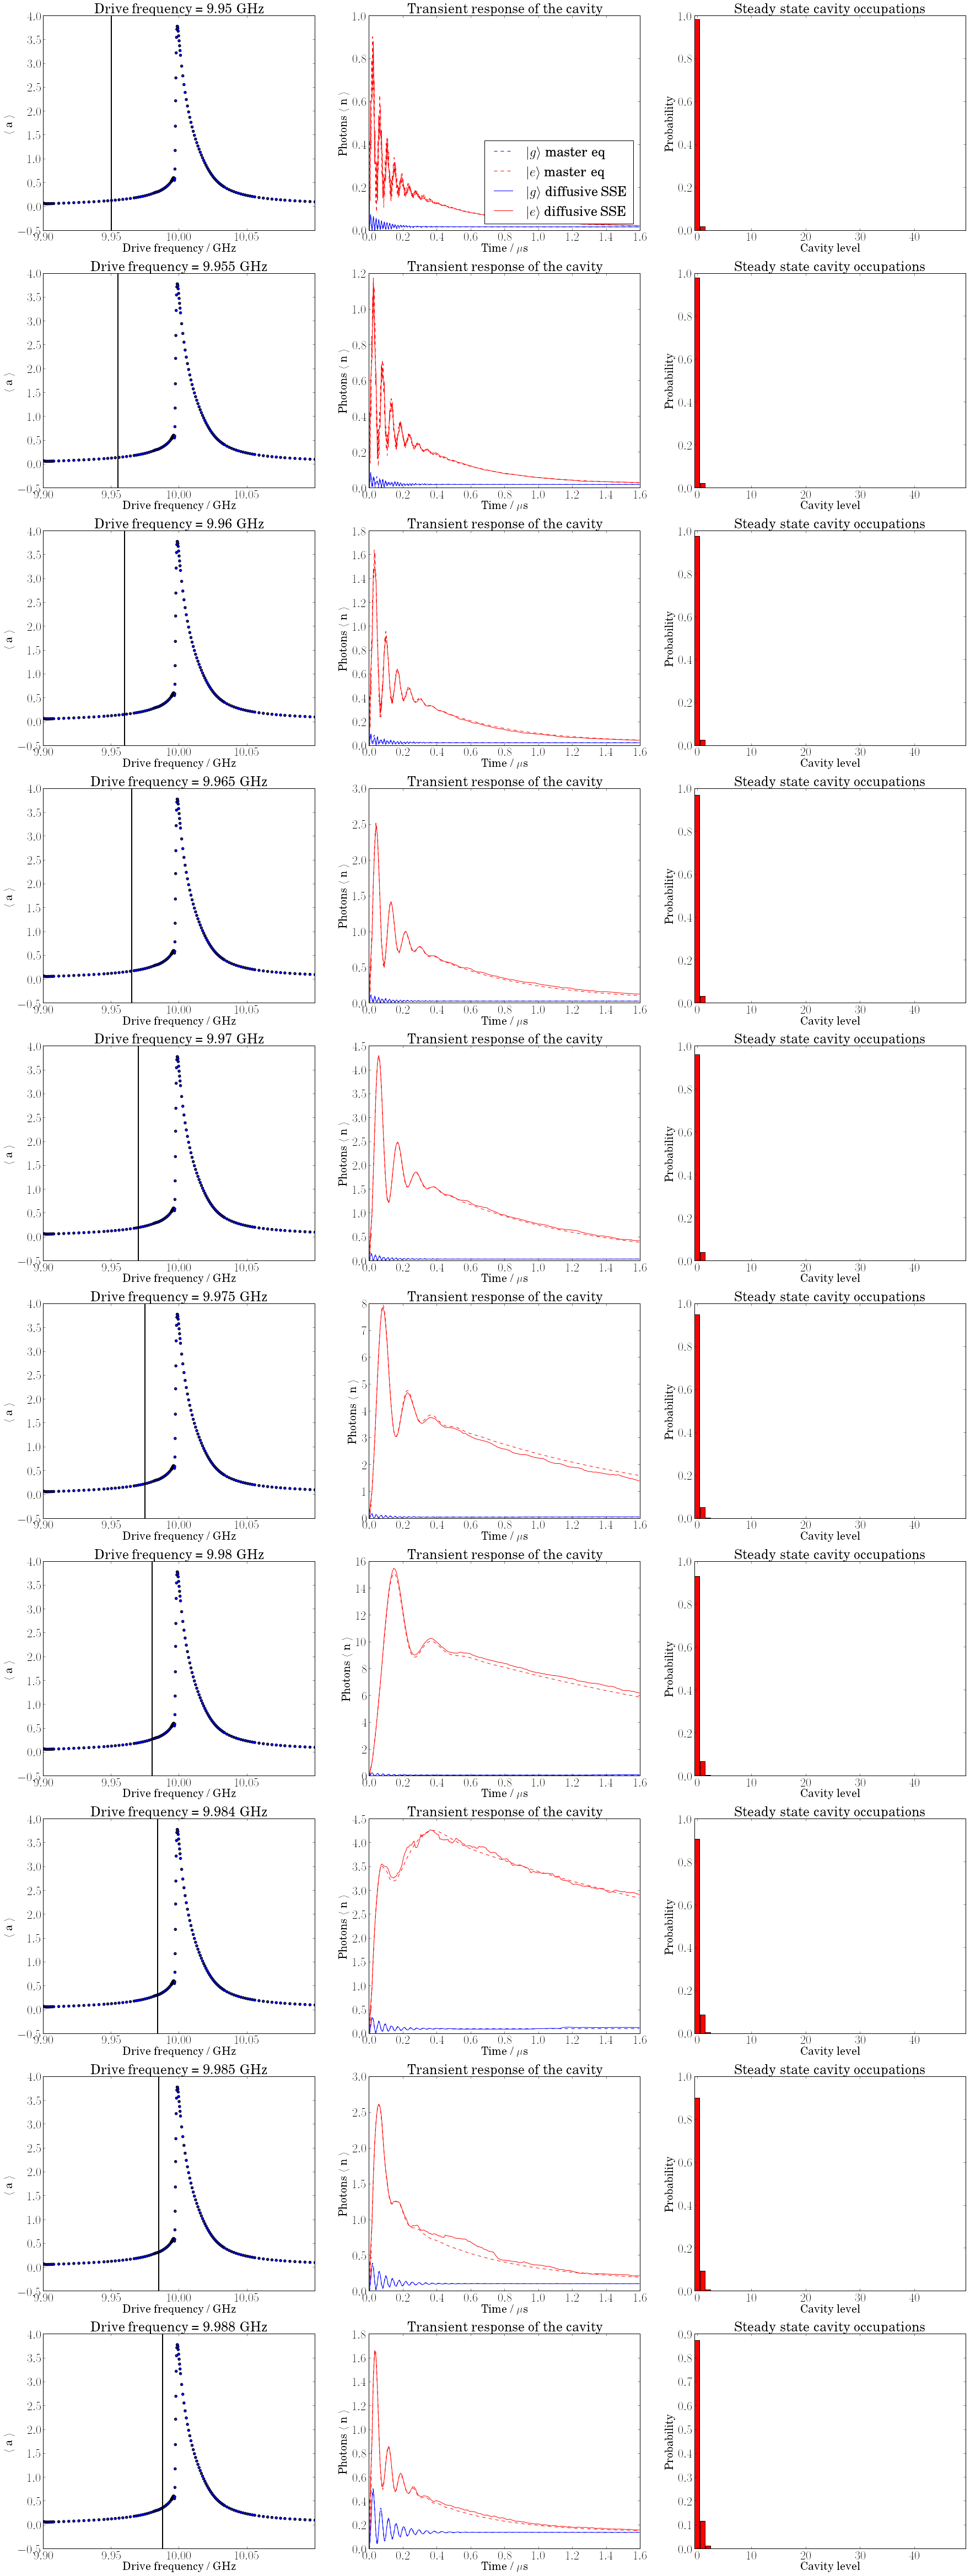

In [15]:
sweep.plot(window=[0,10], col3='steady_states')

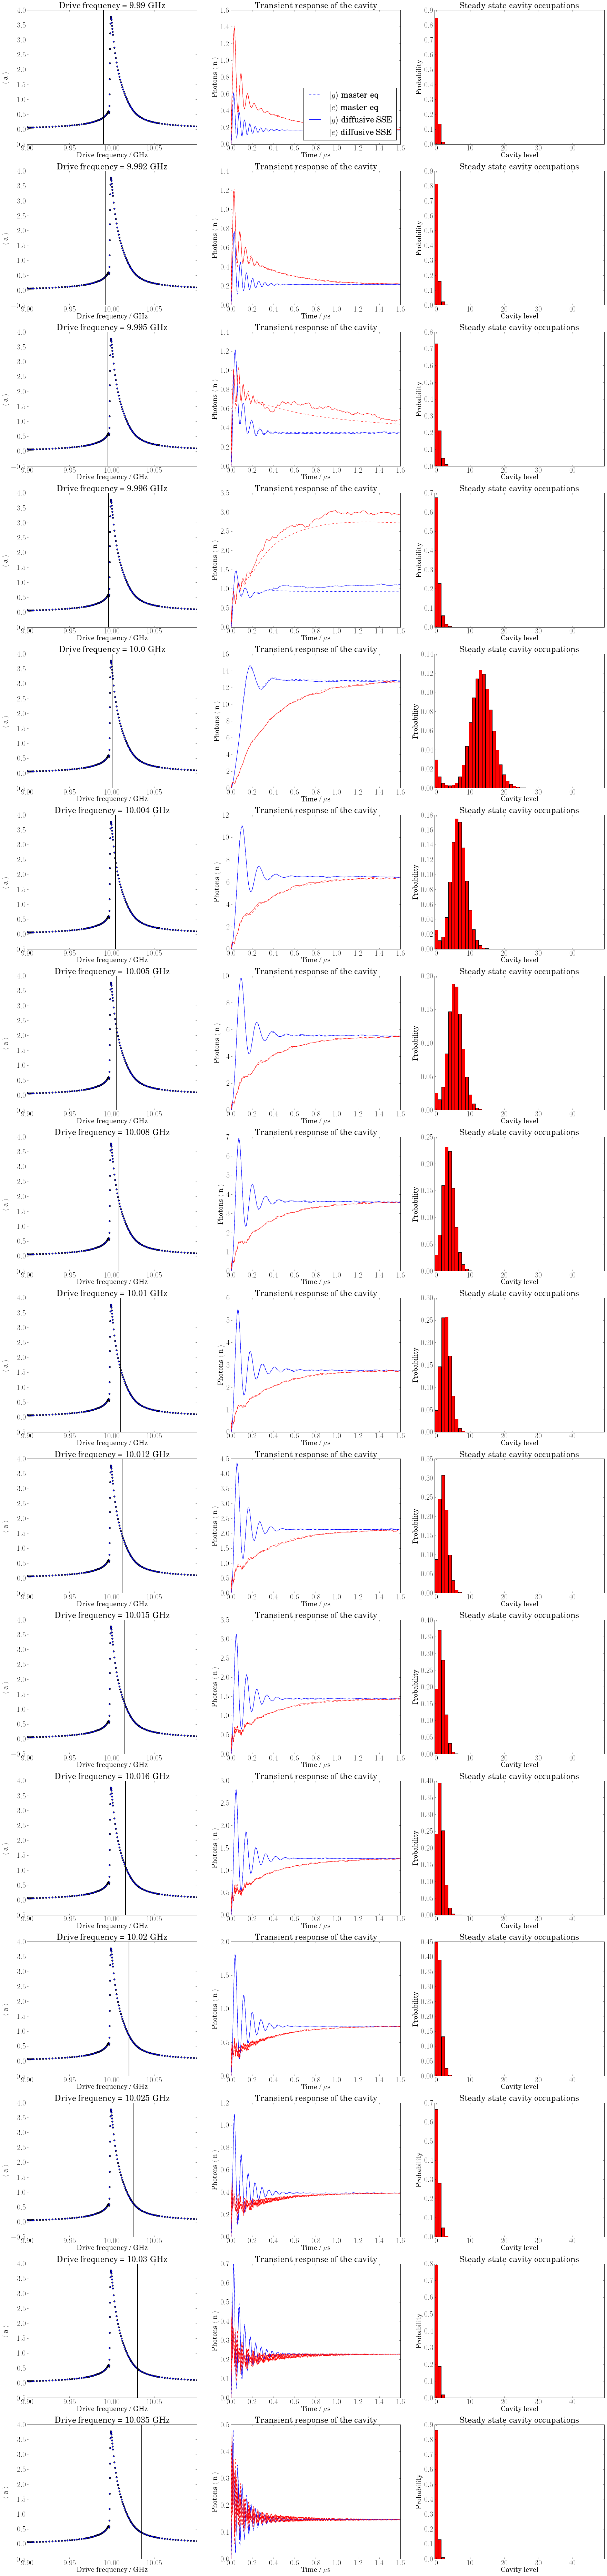

In [16]:
sweep.plot(window=[10,26], col3='steady_states')